Installations

In [1]:
%pip install matplotlib pandas openpyxl

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Imports

In [28]:
import subprocess
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

Preparing folder

In [3]:
examples_folder_path = '../examplesGenerator/'
results_folder_path = f"{examples_folder_path}results/"
n_iterations = 10
programs_rand_seed = 0
programs_loops_factor = 40
var_type = "scalar"
subprocess.run(f"mkdir {results_folder_path}", shell=True, stderr=subprocess.DEVNULL)
subprocess.run(f"rm {results_folder_path}*", shell=True, stderr=subprocess.DEVNULL)
subprocess.run(f"cd {examples_folder_path} && python3 examplesGenerator.py 4 {n_iterations} {var_type}", shell=True, check=True)


############################################################
COMPILING 10 production_rules/production_rule_6.txt scalar
Done!
############################################################

############################################################
COMPILING 10 production_rules/production_rule_7.txt scalar
Done!
############################################################

############################################################
COMPILING 10 production_rules/production_rule_8.txt scalar
Done!
############################################################

############################################################
COMPILING 10 production_rules/production_rule_9.txt scalar
Done!
############################################################

############################################################
COMPILING 10 production_rules/production_rule_10.txt scalar
Done!
############################################################

##########################################################

CompletedProcess(args='cd ../examplesGenerator/ && python3 examplesGenerator.py 4 10 scalar', returncode=0)

Gathering data

In [4]:
def get_program_compilation_time(file,opt):
    time_result : subprocess.CompletedProcess = subprocess.run(f"time clang -o output.o {opt} {file}",
                                                               check=True, shell=True, capture_output=True, text=True)
    if time_result.returncode != 0:
        print(f"Error in {file}")
        sys.exit(1)
    elapsed_time_str = time_result.stderr.split(' ')[2]
    time_str = elapsed_time_str.replace('elapsed', '')
    time_str_list = time_str.split(':')
    secs = float(time_str_list[-1])
    mins = 0
    if len(time_str_list) >= 2:
        mins = int(time_str_list[-2])
    hours = 0
    if len(time_str_list) >= 3:
        hours = int(time_str_list[0])
    return hours*3600 + mins*60 + secs

def get_program_running_time(file,opt):
    time_result : subprocess.CompletedProcess = subprocess.run(f"time ./output.o {programs_rand_seed} {programs_loops_factor}",
                                                               check=True, shell=True, capture_output=True, text=True)
    if time_result.returncode != 0:
        print(f"Error in {file}")
        sys.exit(1)
    elapsed_time_str = time_result.stderr.split(' ')[2]
    time_str = elapsed_time_str.replace('elapsed', '')
    time_str_list = time_str.split(':')
    secs = float(time_str_list[-1])
    mins = 0
    if len(time_str_list) >= 2:
        mins = int(time_str_list[-2])
    hours = 0
    if len(time_str_list) >= 3:
        hours = int(time_str_list[0])
    return hours*3600 + mins*60 + secs

def get_program_size(file) -> int:
    size_result : subprocess.CompletedProcess = subprocess.run(f"size output.o", shell=True, capture_output=True, text=True)
    if size_result.returncode != 0:
        print(f"Error in {file}")
        sys.exit(1)
    size_str = size_result.stdout.split('\n')[1].split('\t')
    return int(size_str[0])

def get_program_cpu_cycles() -> int:
    subprocess.run(f"perf stat -o temp.txt -e cycles ./output.o {programs_rand_seed} {programs_loops_factor}", shell=True, check=True)
    with open('temp.txt', 'r') as f:
        lines = f.readlines()
        lines = [line for line in lines if line.strip() != '']
        words = lines[2].strip().split(' ')
        cycles = int(words[0].replace('.', ''))
    return cycles

In [5]:
recursive_calls = []
optimizations = []
sizes = []
cpu_cycles = []
running_times = []
compilation_times = []
opts = ['-O0', '-O1', '-O2', '-O3']#, '-Os', '-Oz', '-Ofast']
for i, file in enumerate(os.listdir(results_folder_path)):
    try:
        info_array = file.split('_')
        production_rule = int(info_array[2])
        for opt in opts:
            recursive_calls.append(production_rule)
            optimizations.append(opt)
            print(f"Compiling {file} with optimization {opt}")
            time = get_program_compilation_time(results_folder_path+file,opt)
            compilation_times.append(time)
            print(f"    time: {time}")
            print(f"Running {file} with optimization {opt}")
            time = get_program_running_time(results_folder_path+file,opt)
            running_times.append(time)
            print(f"    time: {time}")
            sizes.append(get_program_size(file))
            print(f"Getting cpu cycles for {file} with optimization {opt}")
            cpu_cycles.append(get_program_cpu_cycles())
    except Exception as e:
        print(e)
        print(f"Error in {file} with optimization {opt}. Iteration {i}")
        sys.exit(1)
subprocess.run(f"rm output.o temp.txt", shell=True)

Compiling output_10_6_scalar.c with optimization -O0
    time: 0.1
Running output_10_6_scalar.c with optimization -O0
    time: 0.5
Getting cpu cycles for output_10_6_scalar.c with optimization -O0
Compiling output_10_6_scalar.c with optimization -O1
    time: 0.15
Running output_10_6_scalar.c with optimization -O1
    time: 0.33
Getting cpu cycles for output_10_6_scalar.c with optimization -O1
Compiling output_10_6_scalar.c with optimization -O2
    time: 0.13
Running output_10_6_scalar.c with optimization -O2
    time: 0.3
Getting cpu cycles for output_10_6_scalar.c with optimization -O2
Compiling output_10_6_scalar.c with optimization -O3
    time: 0.16
Running output_10_6_scalar.c with optimization -O3
    time: 0.29
Getting cpu cycles for output_10_6_scalar.c with optimization -O3
Compiling output_10_7_scalar.c with optimization -O0
    time: 0.06
Running output_10_7_scalar.c with optimization -O0
    time: 1.73
Getting cpu cycles for output_10_7_scalar.c with optimization -O0
Com

CompletedProcess(args='rm output.o temp.txt', returncode=0)

### Building tables

In [6]:
df = pd.DataFrame({'Recursive Calls': recursive_calls, 'Optimizations': optimizations, 'Size (bytes)': sizes, 'CPU Cycles': cpu_cycles, 'Compilation Time (s)': compilation_times, 'Running Time (s)': running_times})

Getting Ratios to -O0

In [7]:
df['CPU Cycles ratio from O0'] = 1.0
df['Compilation time ratio from O0'] = 1.0
df['Running time ratio from O0'] = 1.0

for call in df['Recursive Calls'].unique():
    o0_row = df[(df['Recursive Calls'] == call) & (df['Optimizations'] == '-O0')].iloc[0]
    
    o0_cpu_cycles = o0_row['CPU Cycles']
    o0_compilation_time = o0_row['Compilation Time (s)']
    o0_running_time = o0_row['Running Time (s)']

    for index, row in df[df['Recursive Calls'] == call].iterrows():
        if row['Optimizations'] == '-O0':
            df.at[index, 'CPU Cycles ratio from O0'] = None
            df.at[index, 'Compilation time ratio from O0'] = None
            df.at[index, 'Running time ratio from O0'] = None
        else:
            df.at[index, 'CPU Cycles ratio from O0'] = (o0_cpu_cycles / row['CPU Cycles']).round(2)
            df.at[index, 'Compilation time ratio from O0'] = (o0_compilation_time / row['Compilation Time (s)']).round(2)
            df.at[index, 'Running time ratio from O0'] = (o0_running_time / row['Running Time (s)']).round(2)

/tmp/ipykernel_7344/3282126585.py:20: RuntimeWarning: invalid value encountered in scalar divide
  df.at[index, 'Running time ratio from O0'] = (o0_running_time / row['Running Time (s)']).round(2)
/tmp/ipykernel_7344/3282126585.py:20: RuntimeWarning: invalid value encountered in scalar divide
  df.at[index, 'Running time ratio from O0'] = (o0_running_time / row['Running Time (s)']).round(2)


Getting Average Optimization Values

In [24]:
average_df = df.groupby('Optimizations').agg({
    'CPU Cycles': 'mean',
    'Size (bytes)': 'mean',
    'Running Time (s)': 'mean',
    'Compilation Time (s)': 'mean'
}).reset_index()

average_df.columns = ['Optimization', 'Average CPU Cycles', 'Average Size', 'Average Running Time', 'Average Compilation Time']
average_df = average_df.iloc[1:].reset_index(drop=True)

o0_values = average_df[average_df['Optimization'] == '-O0']
average_df['Average CPU Cycles ratio from -O0'] = o0_values['Average CPU Cycles'].values[0] / average_df['Average CPU Cycles']
average_df['Average Size ratio from -O0'] = o0_values['Average Size'].values[0] / average_df['Average Size']
average_df['Average Running Time ratio from -O0'] = o0_values['Average Running Time'].values[0] / average_df['Average Running Time']
average_df['Average Compilation Time ratio from -O0'] = o0_values['Average Compilation Time'].values[0] / average_df['Average Compilation Time']

average_df = average_df.round(2)

print(average_df)

  Optimization  Average CPU Cycles  Average Size  Average Running Time  \
0          -O0        1.441342e+11     271295.78                 32.64   
1          -O1        5.213558e+10      88122.33                 11.49   
2          -O2        5.200722e+10      78004.44                 11.48   
3          -O3        5.144010e+10     111150.33                 11.40   

   Average Compilation Time  Average CPU Cycles ratio from -O0  \
0                      0.23                               1.00   
1                      1.98                               2.76   
2                      1.93                               2.77   
3                      2.90                               2.80   

   Average Size ratio from -O0  Average Running Time ratio from -O0  \
0                         1.00                                 1.00   
1                         3.08                                 2.84   
2                         3.48                                 2.84   
3             

Getting Averages

In [25]:
avg_size = round(df['Size (bytes)'].mean(skipna=True), 2)
avg_cpu_cycles = round(df['CPU Cycles'].mean(skipna=True), 2)
avg_compilation_time = round(df['Compilation Time (s)'].mean(skipna=True), 2)
avg_running_time = round(df['Running Time (s)'].mean(skipna=True), 2)
avg_cpu_cycles_ratio = round(df['CPU Cycles ratio from O0'].mean(skipna=True), 2)
avg_compilation_time_ratio = round(df['Compilation time ratio from O0'].mean(skipna=True), 2)
avg_running_time_ratio = round(df['Running time ratio from O0'].mean(skipna=True), 2)

average_row = pd.DataFrame({
    'Recursive Calls': ['Average'],
    'Optimizations': [''],
    'Size (bytes)': [avg_size],
    'CPU Cycles': [avg_cpu_cycles],
    'Compilation Time (s)': [avg_compilation_time],
    'Running Time (s)': [avg_running_time],
    'CPU Cycles ratio from O0': [avg_cpu_cycles_ratio],
    'Compilation time ratio from O0': [avg_compilation_time_ratio],
    'Running time ratio from O0': [avg_running_time_ratio]
})
df = pd.concat([df, average_row], ignore_index=True)

Sorting

In [26]:

df.sort_values(by=['Recursive Calls', 'Optimizations'], inplace=True)
average_df.sort_values(by=['Optimization'], inplace=True)

Exporting data to files

In [27]:
subprocess.run(f"mkdir results", shell=True, stderr=subprocess.DEVNULL)
df.to_csv('results/main_table.csv', index=False)
average_df.to_csv('results/average_table.csv', index=False)

with pd.ExcelWriter('results/tables.xlsx') as writer:
    df.to_excel(writer, sheet_name='Main Table', index=False)
    average_df.to_excel(writer, sheet_name='Average Table', index=False)

### Generating Graphs

In [1]:
file_name = 'results/graphs.pdf'
subprocess.run(f"rm {file_name}", shell=True)
pdf_file = PdfPages(file_name)
data = average_df

plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
})

NameError: name 'subprocess' is not defined

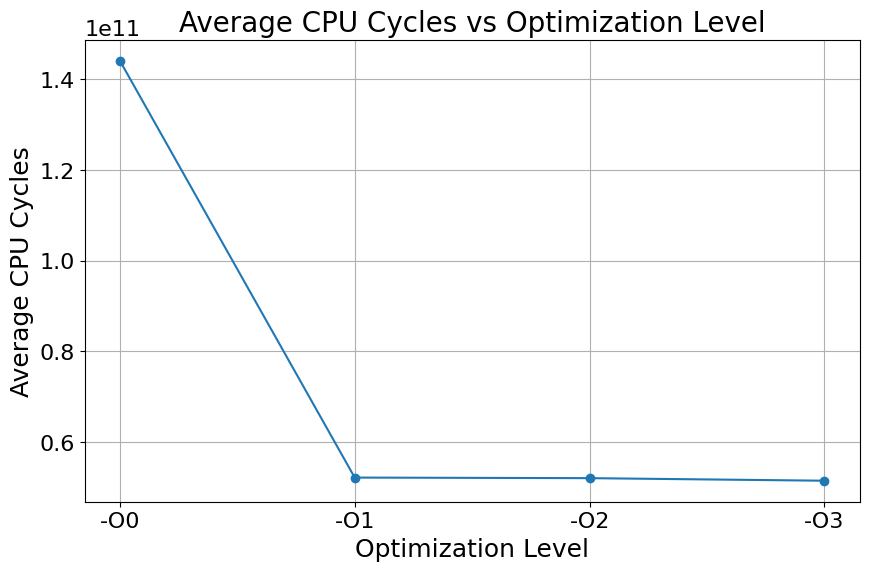

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data['Optimization'], data['Average CPU Cycles'], marker='o')
plt.title('Average CPU Cycles vs Optimization Level')
plt.xlabel('Optimization Level')
plt.ylabel('Average CPU Cycles')
plt.grid(True)
pdf_file.savefig()
plt.show()
plt.close()

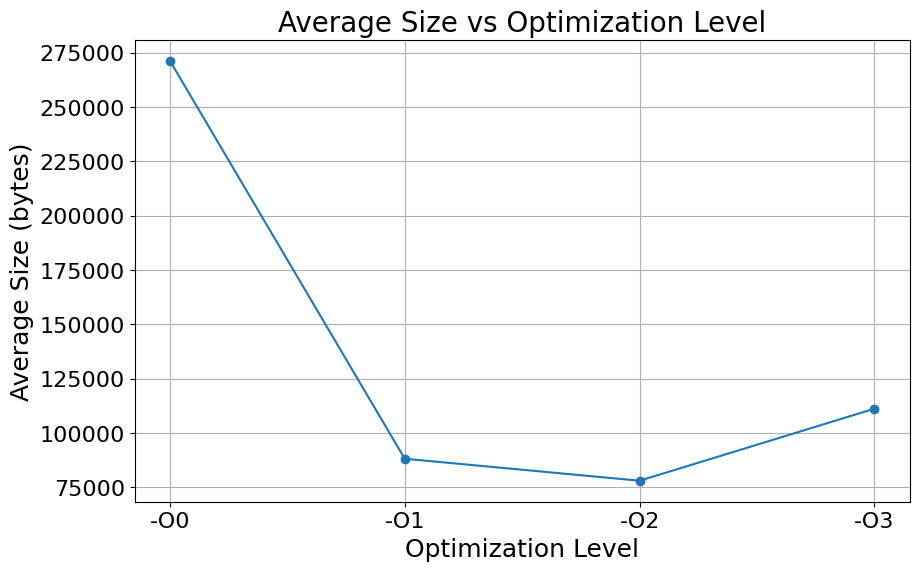

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data['Optimization'], data['Average Size'], marker='o')
plt.title('Average Size vs Optimization Level')
plt.xlabel('Optimization Level')
plt.ylabel('Average Size (bytes)')
plt.grid(True)
pdf_file.savefig()
plt.show()
plt.close()

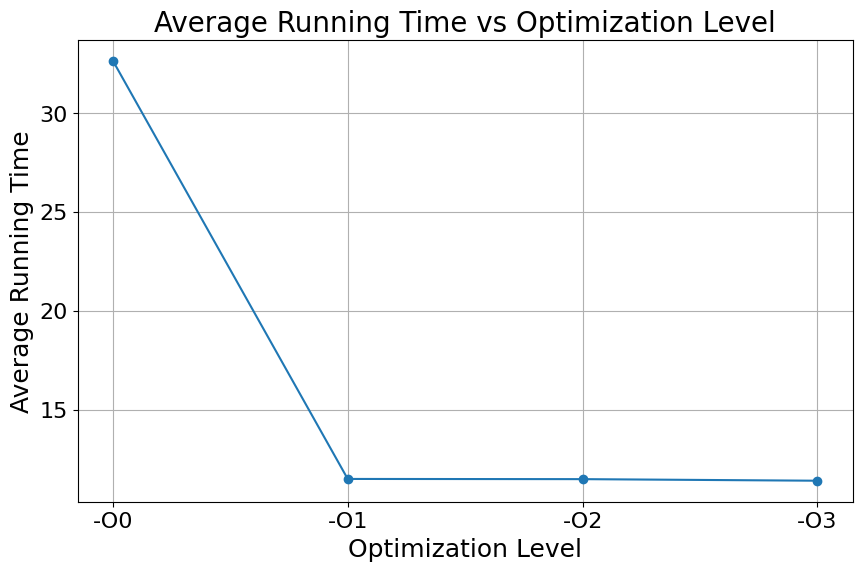

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data['Optimization'], data['Average Running Time'], marker='o')
plt.title('Average Running Time vs Optimization Level')
plt.xlabel('Optimization Level')
plt.ylabel('Average Running Time')
plt.grid(True)
pdf_file.savefig()
plt.show()
plt.close()

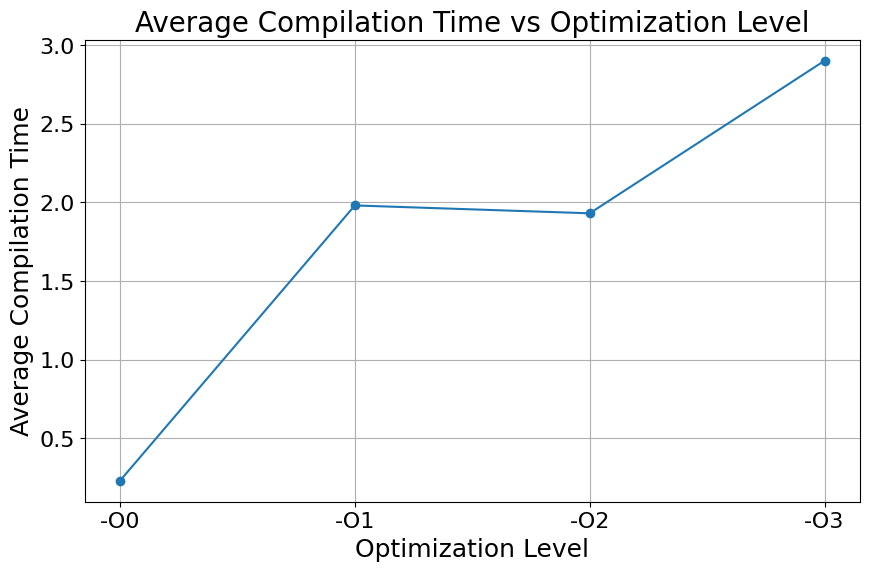

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data['Optimization'], data['Average Compilation Time'], marker='o')
plt.title('Average Compilation Time vs Optimization Level')
plt.xlabel('Optimization Level')
plt.ylabel('Average Compilation Time')
plt.grid(True)
pdf_file.savefig()
plt.show()
plt.close()

In [ ]:
pdf_file.close()